In [ ]:
# default_exp interp

# 01_Interpret
> This module contains the base for `SHAP` interpretation.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastshap.core import _prepare_data, _predict
import shap
from fastai2.tabular.all import *

First let's train a model to analyze

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [ ]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]

In [ ]:
splits = IndexSplitter(list(range(800,1000)))(range_of(df))
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits)
dls = to.dataloaders()

And fit it

In [ ]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.363123,0.379660,0.815000,00:08


In [ ]:
#export
class ShapInterpretation():
  "Base interpereter to use the `SHAP` interpretation library"
  def __init__(self, learn:TabularLearner, test_data=None, link='identity', l1_reg='auto', n_samples=128, **kwargs):
    "Initialize `ShapInterpretation` with a Learner, test_data, link, `n_samples`, `l1_reg`, and optional **kwargs"
    self.model = learn.model
    self.dls = learn.dls
    self.class_names = learn.dl.vocab
    self.train_data = pd.merge(learn.dls.cats, learn.dls.conts, left_index=True, right_index=True)
    self.test_data = _prepare_data(learn, test_data, n_samples)
    pred_func = partial(_predict, learn)
    self.explainer = shap.SamplingExplainer(pred_func, self.train_data, **kwargs)
    self.shap_vals = self.explainer.shap_values(self.test_data, l1_reg=l1_reg)
    self.is_multi_output = isinstance(self.shap_vals, list)

  def decision_plot(self, class_id=0, row_idx=-1, **kwargs):
    "Visualize model decision using cumulative `SHAP` values."
    shap_vals, exp_val = _get_values(self, class_id)
    n_rows = shap_vals.shape[0]
    if row_idx == -1:
      print(f'Displaying rows 0-9 of {n_rows} (use `row_idx` to specify another row)')
      return shap.decision_plot(exp_val, shap_vals[:10], self.test_data.iloc[:10], **kwargs)
    print(f'Displaying row {row_idx} of {n_rows} (use `row_idx` to specify another row)')
    return shap.decision_plot(exp_val, shap_vals[row_idx], self.test_data.iloc[row_idx], **kwargs)

  def dependence_plot(self, variable_name:str="", class_id=0, **kwargs):
    "Plots value of variable on the x-axis and the SHAP value of the same variable on the y-axis"
    if variable_name is "":
      raise ValueError('No variable passed in for `variable_name`')
    shap_vals, _ = _get_values(self, class_id)
    return shap.dependence_plot(variable_name, shap_vals, self.test_data, **kwargs)

  def force_plot(self, class_id=0, matplotlib=False, **kwargs):
    "Visualize the `SHAP` values with additive force layout"
    shap_vals, exp_val = _get_values(self, class_id)
    if not matplotlib: shap.initjs()
    return shap.force_plot(exp_val, shap_vals, self.test_data, matplotlib=matplotlib, **kwargs)

  def summary_plot(self, **kwargs):
    "Displays `SHAP` values which can be interperated for feature importance"
    return shap.summary_plot(self.shap_vals, self.test_data, class_names=self.class_names, **kwargs)

  def waterfall_plot(self, row_idx=None, class_id=0, **kwargs):
    "Plots explaination of single prediction as waterfall plot"
    shap_vals, exp_val = _get_values(self, class_id)
    n_rows = shap_vals.shape[0]
    row_idx = random.randint(0, n_rows-1) if row_idx is None else row_idx
    print(f'Displaying row {row_idx} of {n_rows} (use `row_idx` to specify another row)')
    feat_names = self.test_data.columns
    return shap.waterfall_plot(exp_val, shap_vals[row_idx,:], feature_names=feat_names, **kwargs)

In [ ]:
#export
def _get_class_info(interp:ShapInterpretation, class_id):
  "Returns class name associated with index, or vice-versa"
  if isinstance(class_id, int): class_idx, class_name = class_id, interp.class_names[class_id]
  else: class_idx, class_name = interp.class_names.o2i[class_id], class_id
  return (class_name, class_idx)

In [ ]:
#export
def _get_values(interp:ShapInterpretation, class_id=0):
  "Returns `shap_value` and `expected_value`"
  shap_vals = interp.shap_vals
  exp_vals = interp.explainer.expected_value
  if interp.is_multi_output:
    (class_name, class_idx) = _get_class_info(interp, class_id)
    print(f"Classification model detected, displaying score for the class {class_name}.")
    print("(use `class_id` to specify another class)")
    return (shap_vals[class_idx], exp_vals[class_idx])
  return (shap_vals, exp_vals)

> This class allows you to utilize various methods within the `SHAP` interpretation library. Currently `summary_plot`, `dependence_plot`, `waterfall_plot`, `force_plot`, and `decision_plot` are supported. 
  * `test_data` should be either a `Pandas` dataframe or a `TabularDataLoader`. If not, 100 random rows of the training data will be used instead.
  * `link` can either be "identity" or "logit". A generalized linear model link to connect the feature importance values to the model output. Since the feature importance values, phi, sum up to the model output, it often makes sense to connect them to the ouput with a link function where link(outout) = sum(phi). If the model output is a probability then the LogitLink link function makes the feature importance values have log-odds units.
  * `n_samples` can either be "auto" or an integer value. This is the number of times to re-evaluate the model when explaining each predictions. More samples leads to lower variance estimations of the `SHAP` values
  * `l1_reg` can be: an integer value representing the number of features, "auto", "aic", "bic", or a float value. The l1 regularization to use for feature selection (the estimation procedure is based on a debiased lasso). The auto option currently uses "aic" when less that 20% of the possible sample space is enumerated, otherwise it uses no regularization.

In [ ]:
exp = ShapInterpretation(learn)

### `decision_plot`

> Visualizes a model's decisions using cumulative `SHAP` values. Accepts a `class_id` which is used to indicate the class of interest for a classification model. It can either be an `int` or `str` representation for a class of choice. Each colored line in the plot represents the model's prediction for a single observation. If no index is passed in to use from the data, it will default to the first ten samples on the test set. **Note: plotting too many samples at once can make the plot illegible.** For an up-to-date list of parameters, see [here](https://github.com/slundberg/shap/blob/master/shap/plots/decision.py) and for more information see [here](https://github.com/slundberg/shap/blob/master/notebooks/plots/decision_plot.ipynb)

Classification model detected, displaying score for the class <50k.
(use `class_id` to specify another class)
Displaying row 10 of 128 (use `row_idx` to specify another row)


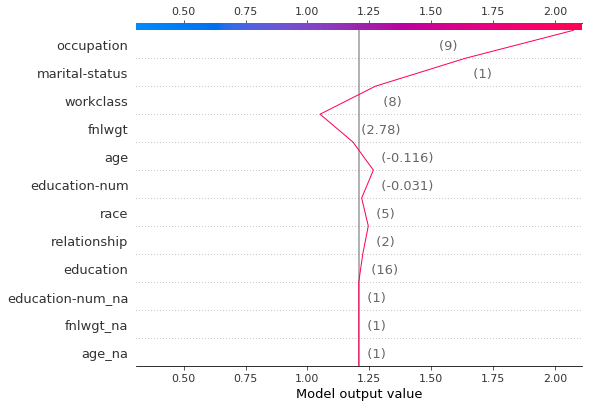

In [ ]:
exp.decision_plot(class_id=0, row_idx=10)

### `dependence_plot`
> Plots the value of a variable on the x-axis and the `SHAP` value of the same variable on the y-axis. Accepts a `class_id` and `variable_name`. `class_id`  is used to indicate the class of interest for a classification model. It can either be an `int` or `str` representation for a class of choice. This plot shows how the model depends on the given variable. Vertical dispersion of the datapoints represent interaction effects. Gray ticks along the y-axis are datapoints where the variable's values were `NaN`. For an up-to-date list of parameters, see [here](https://github.com/slundberg/shap/blob/master/shap/plots/dependence.py) and for more information see [here](https://github.com/slundberg/shap/blob/master/notebooks/plots/dependence_plot.ipynb)

Classification model detected, displaying score for the class <50k.
(use `class_id` to specify another class)


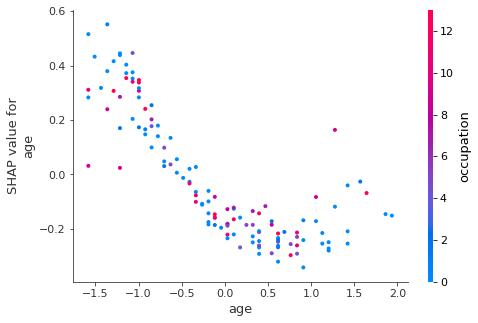

In [ ]:
exp.dependence_plot('age', class_id=0)

### `force_plot`
> Visualizes the `SHAP` values with an added force layout. Accepts a `class_id` which is used to indicate the class of interest for a classification model. It can either be an `int` or `str` representation for a class of choice. `matplotlib` determines if it should be shown using matplotlib or in JavaScript. For an up-to-date list of parameters, see [here](https://github.com/slundberg/shap/blob/master/shap/plots/force.py)

In [ ]:
exp.force_plot(class_id=0)

Classification model detected, displaying score for the class <50k.
(use `class_id` to specify another class)


### `summary_plot`
> Displays the SHAP values (which can be interpreted for feature importance)
For an up-to-date list of parameters, see [here](https://github.com/slundberg/shap/blob/master/shap/plots/summary.py)

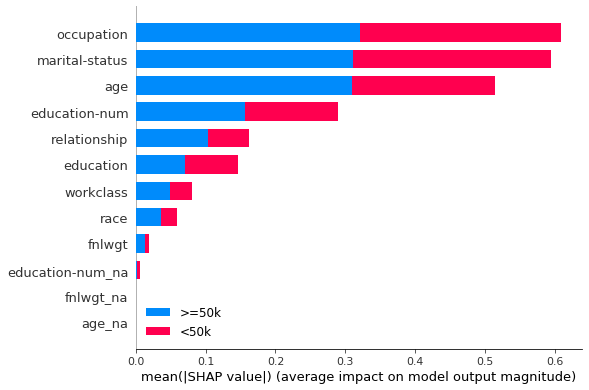

In [ ]:
exp.summary_plot()

### `waterfall_plot`
> Plots an explanation of a single prediction as a waterfall plot. Accepts a `row_index` and `class_id`. `row_index` is the index of the row chosen in `test_data` to be analyzed, which defaults to zero. Accepts a `class_id` which is used to indicate the class of interest for a classification model. It can either be an `int` or `str` representation for a class of choice. For an up-to-date list of parameters, see [here](https://github.com/slundberg/shap/blob/master/shap/plots/waterfall.py)

Classification model detected, displaying score for the class <50k.
(use `class_id` to specify another class)
Displaying row 10 of 128 (use `row_idx` to specify another row)


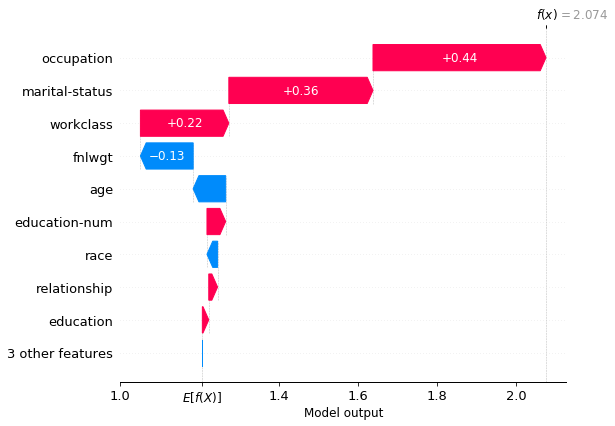

In [ ]:
exp.waterfall_plot(row_idx=10)